## Estadística Aplicada

Nombre: Barbara Govea Serna

Matrícula: 1902869

Grupo: 042

Fecha: 25-Oct-2023

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,plot_predict
from statsmodels.tsa.arima.model import ARIMA 

import pmdarima as pm 

In [3]:
desempleo_mex = pd.read_excel('desempleo_mex.xlsx')

In [6]:
desempleo_mex.dtypes

meses                 object
tasa de desempleo    float64
dtype: object

In [7]:
desempleo_mex.head()

,meses,tasa de desempleo
0,2005/01,3.951998
1,2005/02,3.773302
2,2005/03,3.627075
3,2005/04,3.363412
4,2005/05,3.303693


In [8]:
## Convertir en tiempo, hacerlo index, asignarle frecuencia 
desempleo_mex['meses'] = pd.to_datetime(desempleo_mex['meses'], format='%Y/%m')
desempleo_mex = desempleo_mex.set_index('meses')
desempleo_mex= desempleo_mex.asfreq('MS') # Sintaxis mes

In [9]:
desempleo_mex.index

DatetimeIndex(['2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01',
               '2005-05-01', '2005-06-01', '2005-07-01', '2005-08-01',
               '2005-09-01', '2005-10-01',
               ...
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01'],
              dtype='datetime64[ns]', name='meses', length=224, freq='MS')

In [11]:
desempleo_mex.isnull().sum()

tasa de desempleo    0
dtype: int64

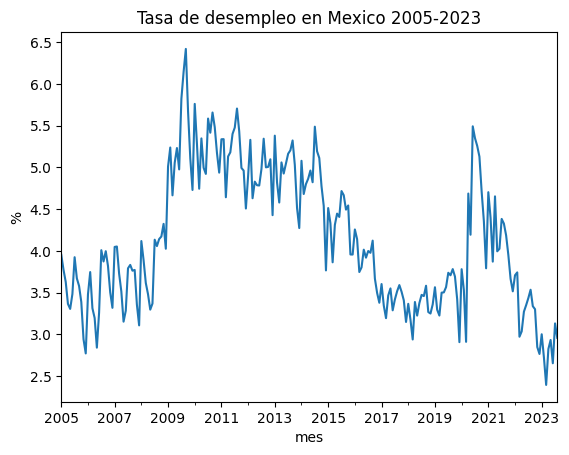

In [13]:
# Graficamos serie de tiempo
desempleo_mex['tasa de desempleo'].plot()
plt.xlabel('mes')
plt.ylabel('%')
plt.title('Tasa de desempleo en Mexico 2005-2023')
plt.show()

In [14]:
# Prueba de Dickey Fuller Aumentada
prueba_adf= adfuller(desempleo_mex['tasa de desempleo'])
pvalue = prueba_adf[1]
pvalue.round(2)

0.25

No rechazamos H0 por lo que la serie de desempleo es no es estacionaria 

In [15]:
# primeras diferencias 
desempleo_mex['desempleo_diff'] = desempleo_mex['tasa de desempleo'].diff()

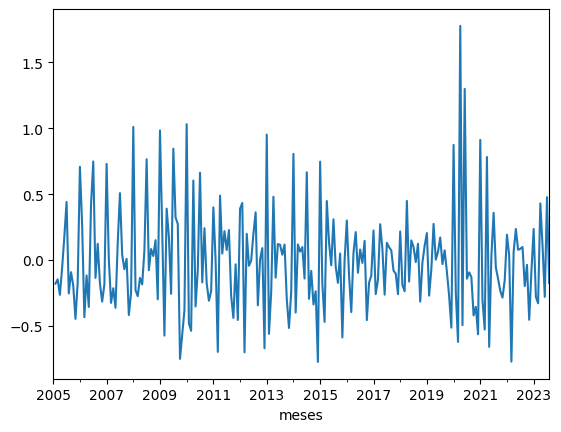

In [20]:
desempleo_mex['desempleo_diff'].plot();

In [22]:
# Prueba de Dickey Fuller Aumentada para las primeras diferencias 
prueba_adf1= adfuller(desempleo_mex['desempleo_diff'].dropna())
pvalue1 = prueba_adf1[1]
pvalue1.round(2)

0.01

Rechazamos H0, por lo que la serie de las primeras diferencias de desempleo es estacionaria 

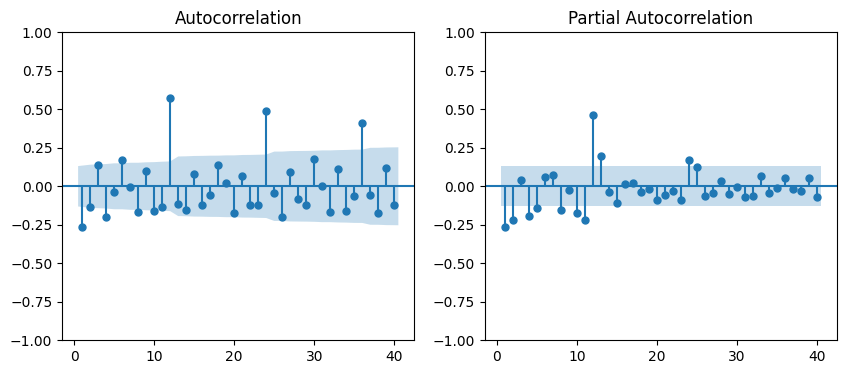

In [25]:
# Graficas de correlación 
ig, ax = plt.subplots(1,2, figsize=(10,4))
# 1er grafica 
plot_acf(desempleo_mex['desempleo_diff'].dropna(),zero=False,lags=40,ax=ax[0])
# 2da grafica
plot_pacf(desempleo_mex['desempleo_diff'].dropna(),zero=False,lags=40,ax=ax[1])
plt.show()


Con las graficas de autocorrelacion dado que emerge un patron que se repite, estamos ante una serie con componente estacioal, es decir, hay meses que el desempleo siempre sube o meses que el desempleo siempre baja.  
Es diferente componente estacional y estacionaria


In [30]:
# Encontrar el orden del SARIMA (SI no tuviera componente estacional solo seria ARIMA)
pm.auto_arima(desempleo_mex['tasa de desempleo'],
              start_p= 1,
              star_q=1 ,
              max_p= 10, 
              max_q=10, # El 7 se lo invento el profe
              ic= 'aic',
              seasonal=True,
              m=12,
              start_P=1,
              start_Q=1,
              max_P=7,
              max_Q=7)

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

La tasa de desempleo es un SARIMA (1,1,0) NO SE PORQ SALE ESO XD

In [29]:
# Modelo
model = ARIMA(desempleo_mex['tasa de desempleo'],
              order = (1,1,0),
              seasonal_order= (1,0,1,12))

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  tasa de desempleo   No. Observations:                  224
Model:             ARIMA(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 -28.306
Date:                            Wed, 25 Oct 2023   AIC                             64.613
Time:                                    15:52:15   BIC                             78.241
Sample:                                01-01-2005   HQIC                            70.115
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3689      0.061     -6.075      0.000      -0.488      -0.250
ar.S.L12       0.9763      0.014   

In [31]:
desempleo_mex['desempleo_arima'] = results.predict()

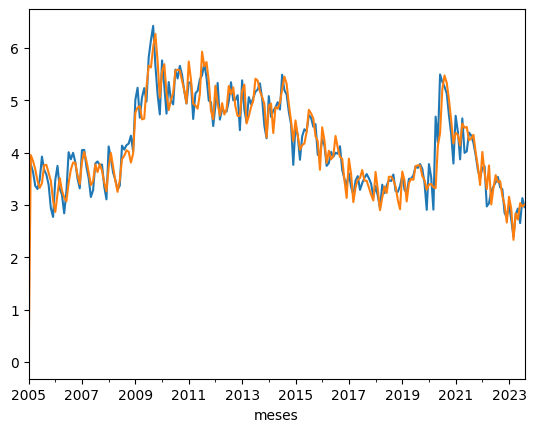

In [33]:
desempleo_mex['tasa de desempleo'].plot()
desempleo_mex['desempleo_arima'].plot();

In [35]:
desempleo_mex.tail()

,tasa de desempleo,desempleo_diff,desempleo_arima
meses,,,
2023-04-01,2.822799,0.430258,2.837606
2023-05-01,2.931125,0.108327,2.722100
2023-06-01,2.652033,-0.279093,3.034390
2023-07-01,3.129870,0.477837,2.968333
2023-08-01,2.955346,-0.174524,3.007015


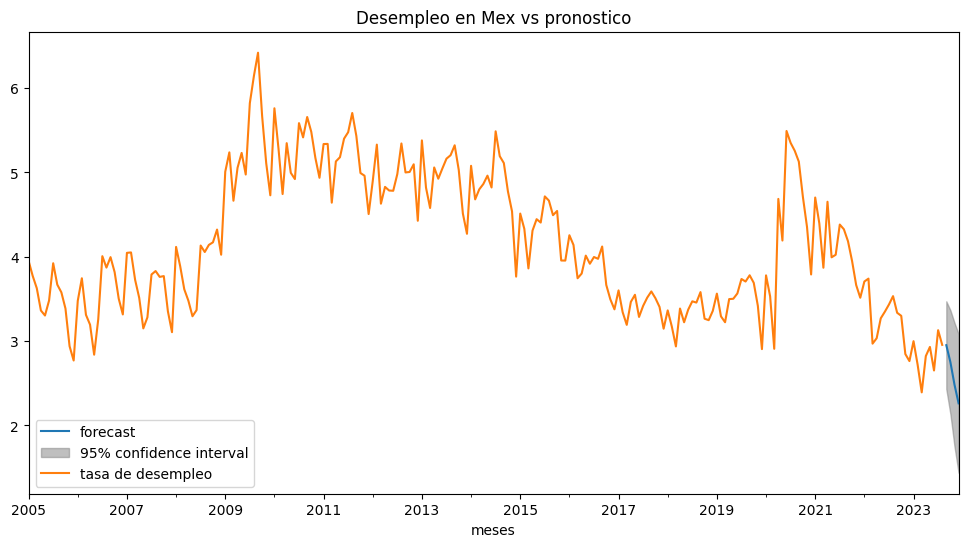

In [37]:
# Grafica del pronostico futuro
plot_predict(results,'2023-09-01','2023-12-01')
desempleo_mex['tasa de desempleo'].plot(figsize=(12,6))
plt.title('Desempleo en Mex vs pronostico')
plt.legend(loc = 'lower left')
plt.show()

Pronostico con los intervalos

In [38]:
forecast = results.get_forecast(steps=4) # septiembre, octubre, noviembre, diciembre
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [39]:
inicio= '2023-09-01'
final= '2023-12-01'

In [41]:
pronostico_valor = forecast_mean[inicio:final]
pronostico_intervalos = forecast_ci.loc[inicio:final]

In [42]:
df_pronostico = pd.DataFrame({'pronostico': pronostico_valor,
                              'limite inferior': pronostico_intervalos.iloc[:,0],
                              'limite superior': pronostico_intervalos.iloc[:,1]
                              })
df_pronostico

,pronostico,limite inferior,limite superior
2023-09-01,2.951735,2.431389,3.472082
2023-10-01,2.750669,2.135374,3.365963
2023-11-01,2.483561,1.750114,3.217009
2023-12-01,2.262441,1.439566,3.085317


In [47]:
print(f'El pronostico de la accion de amazon para el día 01 de septiembre de 2023 es {df_pronostico.iloc[0,0].round(2)}% pero puede estar entre un valor minimo de {df_pronostico.iloc[0,1].round(2)} y un valor máximo de {df_pronostico.iloc[0,2].round(2)}')

El pronostico de la accion de amazon para el día 01 de septiembre de 2023 es 2.95% pero puede estar entre un valor minimo de 2.43 y un valor máximo de 3.47
